In [1]:
from dataset_coco import BrainDataset
from config import (
    TRAIN_DATA_DIR,
    TRAIN_COCO,
    EVAL_DATA_DIR,
    EVAL_COCO,
    MODEL_PATH,
    TRAIN_BATCH_SIZE,
    TRAIN_SHUFFLE_DL,
    NUM_WORKERS_DL,
    NUM_CLASSES,
    NUM_EPOCHS,
    LR,
    MOMENTUM,
    WEIGHT_DECAY
)
from model import get_model_instance_segmentation
from utils import collate_fn, get_transform, save_model

import torch

print("Torch version:", torch.__version__)


Torch version: 2.1.2+cu121


# Evaluation data load

In [2]:
from config import EVAL_DATA_DIR, EVAL_COCO
# create own Dataset
val_dataset = BrainDataset(
    root=EVAL_DATA_DIR, 
    annotation=EVAL_COCO, 
    transforms=get_transform()
)

# own DataLoader
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=TRAIN_SHUFFLE_DL,
    num_workers=NUM_WORKERS_DL,
    collate_fn=collate_fn,
)

eval_transform = get_transform()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


# Model load from checkpoint

In [3]:
from utils import get_transform
from model import get_model_instance_segmentation

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = get_model_instance_segmentation(NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [4]:
from rich import inspect

In [5]:
# Precision and recall  

In [6]:
CONFIDENT_SCORE = 0.8
def remove_under_confident(prediction: dict, score: float):
    """prediction is a dictionary with keys:
    boxes: tensor(n, 4)
    labels: tensor(n, 1)
    scores: tensor(n, 1)
    we need to remove all the results with scores under confident score

    Args:
        predictions (dict): _description_
    """
    results = prediction["scores"]
    criteria_meet = [results > score]
    for key, item in prediction.items():
        prediction[key] = item[criteria_meet]
    return prediction
    
    

In [7]:
model.eval()
with torch.no_grad():
    for batch_idx, (images, annots) in enumerate(val_loader):
        x = images[0]      # Image tensor with shape [3, 630, 640]
        # x = eval_transform(x)
        # convert RGBA -> RGB and move to device
        # x = x[:3, ...].to(device)
        x = x.to(device)
        model = model.to(device)
        prediction = model([x, ])[0]
        remove_under_confident(prediction, CONFIDENT_SCORE)
        print(annots[0])
        break

{'boxes': tensor([[191.0000, 431.0000, 294.0000, 572.5000]]), 'labels': tensor([1]), 'image_id': tensor([2]), 'area': tensor([14574.5000]), 'iscrowd': tensor([0])}


TP (True positive): Model nhận diện nó là mèo và đúng thật bức ảnh đó là mèo.

FP (False positive): Model nhận diện nó là con mèo nhưng nhãn thực tế (label) không phải là con mèo (có thể là con chó…)

TN (True negative): Model nhận diện nó không phải là con mèo và đúng thật là bức ảnh đó không phải là con mèo (oto, xe máy, tokuda,..)

FN (False negative): Model nhận diện nó không phải là con mèo nhưng thực tế nó con mèo.

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import draw_bounding_boxes


image = Image.open("data/test/31_jpg.rf.7ddd7d1b0964a258c819cfc9e721a854.jpg")

# eval_transform = get_transform()

model.eval()
with torch.no_grad():
    for batch_idx, (images, annots) in enumerate(val_loader):
        x = images[0]      # Image tensor with shape [3, 630, 640]
        print(x)
        # x = eval_transform(x)
        # convert RGBA -> RGB and move to device
        # x = x[:3, ...].to(device)
        x = x.to(device)
        model = model.to(device)
        prediction = model([x, ])[0]
        prediction = remove_under_confident(prediction, CONFIDENT_SCORE)
        print(annots[0])
        break

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
{'boxes': tensor([[152., 423., 302., 585.]]), 'labels': tensor([1]), 'image_id': tensor([0]), 'area': tensor([24300.]), 'iscrowd': tensor([0])}


In [9]:
import torchvision.transforms.functional as F
# image = read_image(image)
image = Image.open("data/test/31_jpg.rf.7ddd7d1b0964a258c819cfc9e721a854.jpg")  
image = F.pil_to_tensor(image)  # convert to tensor shape (3,640,640)
image = F.convert_image_dtype(image)    # covert to type for the model

# Do the predict
with torch.no_grad():
    image.to("cpu")
    model.to("cpu")
    prediction = model([image, ])[0]
    prediction = remove_under_confident(prediction, CONFIDENT_SCORE)
    scores = prediction["scores"]
    pred_labels = [f"confident: {score:.3f}" for score in scores]
    pred_boxes = prediction["boxes"].long()

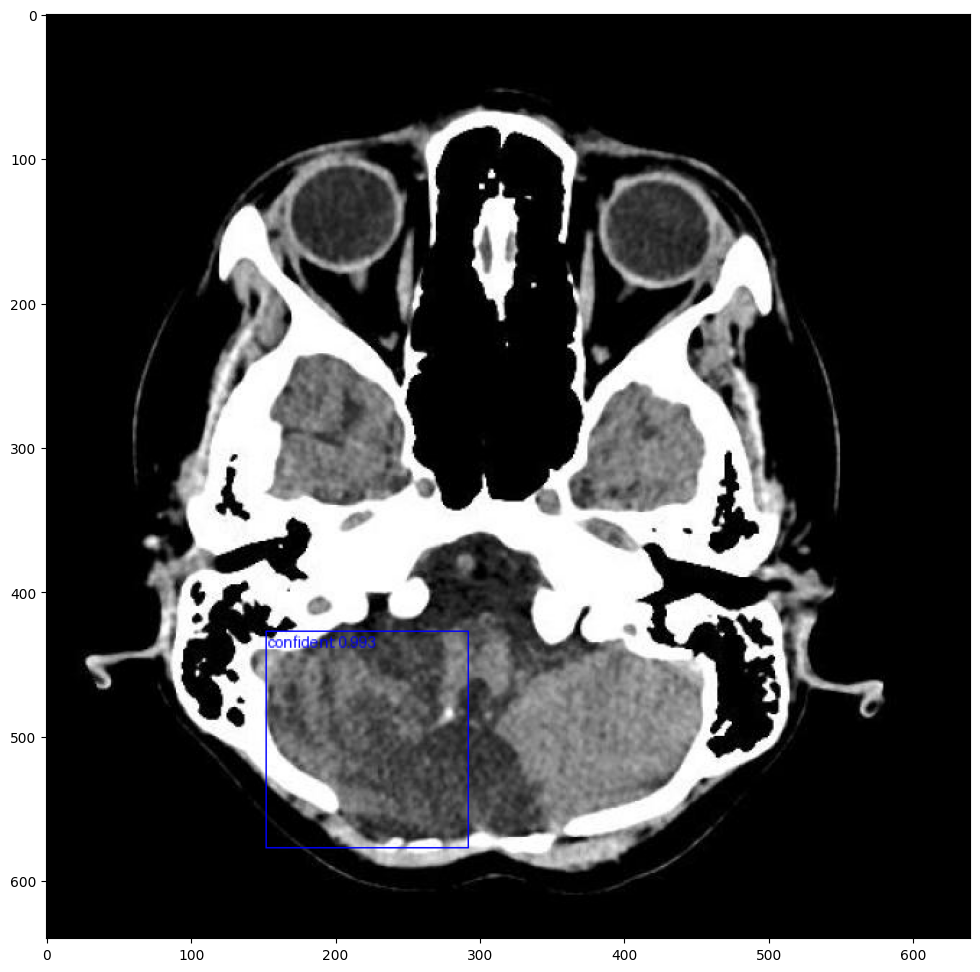

In [10]:
image = Image.open("data/test/31_jpg.rf.7ddd7d1b0964a258c819cfc9e721a854.jpg")
image = F.pil_to_tensor(image)
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="blue")

# masks = (pred["masks"] > 0.7).squeeze(1)
# output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [11]:
print(output_image)

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)
